# **Exploratory Data Analysis**

Throughout the Exploratory Data Analysis (EDA) presented in the following, we will be looking at the Spacecraft Pose Estimation Dataset (SPEED) to determine the best way to prepare it for further processing by a deep learning model. The purpose of the EDA is to better understand the existing patterns in data in order to define a proper pipeline.

### **A brief look at the dataset**

First, let's check the dataset directory. In the `DATASET_PATH` constant I set the local path where I stored the dataset downloaded at the link below.

https://kelvins.esa.int/satellite-pose-estimation-challenge/data

Note in the result of `tree` command that the `images` directory contain satellite images divided into four subsets: `real`, `real_test`, `test` and `train`. Outside this folder, there are four `.json`files corresponding to their respective label associations.

In [1]:
import os

DATASET_PATH = "/home/lfgodoi/Documentos/Datasets/Spacecraft Pose Estimation Dataset (SPEED)/data"
os.system(f"tree -L 2 '{DATASET_PATH}'")

/home/lfgodoi/Documentos/Datasets/Spacecraft Pose Estimation Dataset (SPEED)/data
├── images
│   ├── real
│   ├── real_test
│   ├── test
│   └── train
├── LICENSE.MD
├── real.json
├── real_test.json
├── test.json
└── train.json

6 directories, 5 files


0

For this data exploratory analysis, we will use a few random images from the `train`subset. Let's start by listing the name of all files existing in this folder.

In [2]:
TRAIN_SUBSET_PATH = f"{DATASET_PATH}/images/train"
train_file_names = os.listdir(TRAIN_SUBSET_PATH)

From the file name list, we then randomly select four images to proceed with our investigation. A fixed seed is set to ensure that the results obtained throughout different executions will be deterministic.

In [3]:
import numpy as np
import cv2 as cv

np.random.seed(117)

selected_files = np.random.randint(0, len(train_file_names), 4)
selected_files.sort()
images = {}
for file_name in selected_files:
    image = cv.imread(f"{TRAIN_SUBSET_PATH}/{train_file_names[file_name]}", cv.IMREAD_GRAYSCALE)
    images[file_name] = image
f"Imagens selecionadas: {selected_files}"

'Imagens selecionadas: [ 6224  9328 10577 11758]'

Let's take a look at the images we just selected.

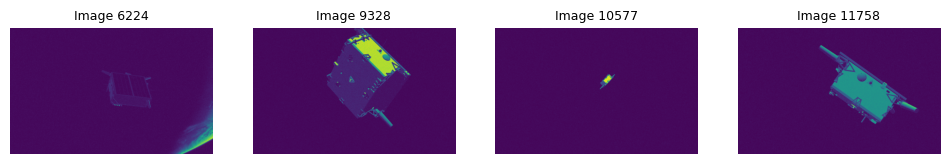

In [4]:
import matplotlib.pyplot as plt

def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 8))
    for i, (filename, image) in enumerate(images.items()):
        axes[i].imshow(image)
        axes[i].set_title(f"Image {filename}", fontsize=9)
        axes[i].axis("off")

display_images(images)

### **Enhancing image quality**

The satellite is the element of interest in every image, but distinguishing it from other elements present is not so easy. An efficient way to visualize this is through the histogram, which plots the distribution of pixel intensity values in relation to the 256 possible values (0 to 255). Sparsely distributed intensities, concentrated in a limited range of values, imply a low level of contrast, making it difficult to distinguish the elements that make up the image.

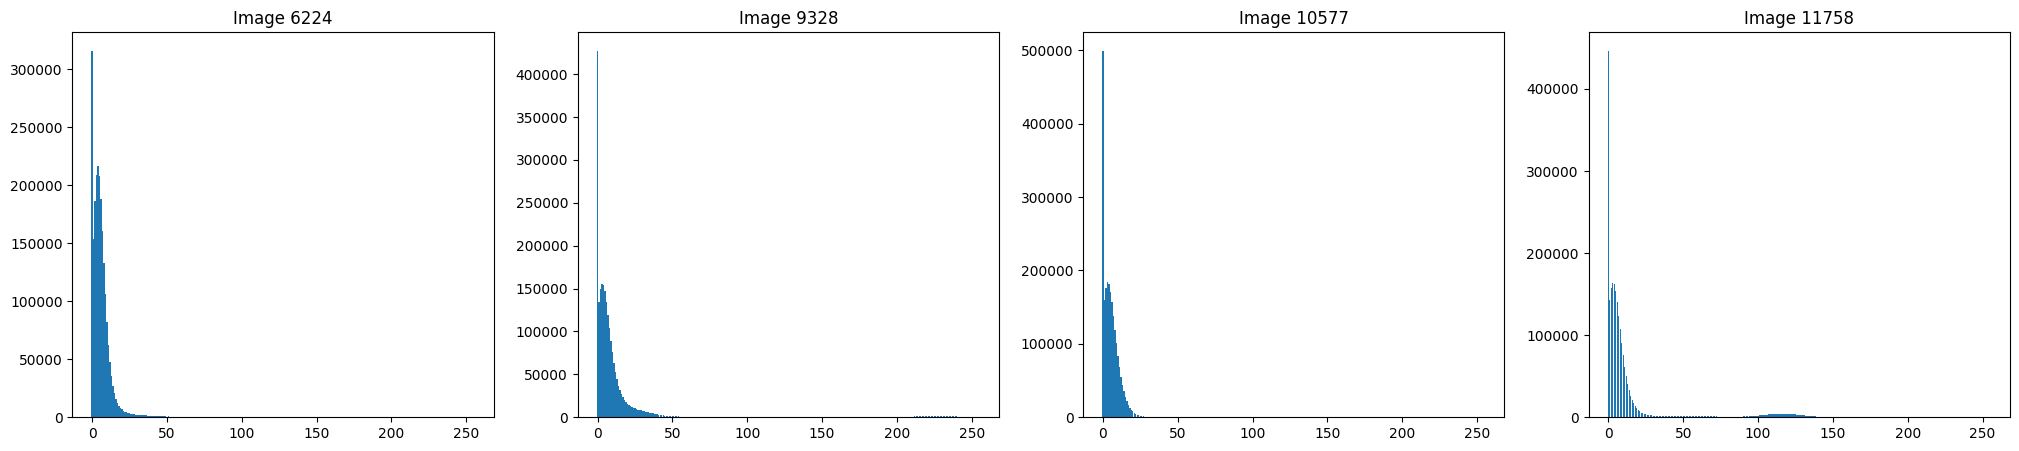

In [5]:
def compute_histograms(images):
    histograms = {}
    for filename, image in images.items():
        histogram = cv.calcHist([image], [0], None, [256], [0, 256])
        histograms[filename] = histogram
    return histograms

histograms = compute_histograms(images)

def plot_histograms(histograms):
    fig, axes = plt.subplots(1, len(images), figsize=(25, 5))
    for i, (filename, histogram) in enumerate(histograms.items()):
        axes[i].bar(np.arange(256), histogram[:, 0])
        axes[i].set_title(f"Image {filename}", fontsize=12)

plot_histograms(histograms)

To mitigate this effect, we will apply histogram equalization, which consists of flattening the distribution of histograms, expanding the variation of intensities in order to facilitate the visual distinction of the different elements. The Contrast Limited Adaptive Histogram Equalization (CLAHE) is a sophisticated technique that equalizes pixels in a local perspective rather than in the global approach used by more common techniques, by dividing the whole image into small blocks called "tiles".

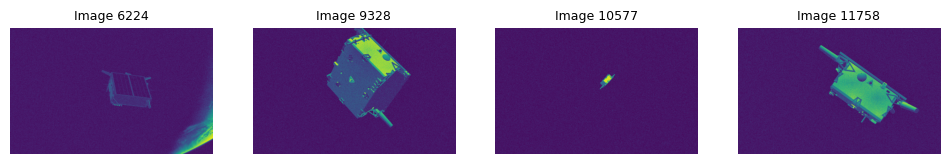

In [6]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized_images = {}
for filename, image in images.items():
    equalized_image = clahe.apply(image)
    # equalized_image = cv.equalizeHist(image)
    equalized_images[filename] = equalized_image

display_images(equalized_images)

And the equalized histograms look like...

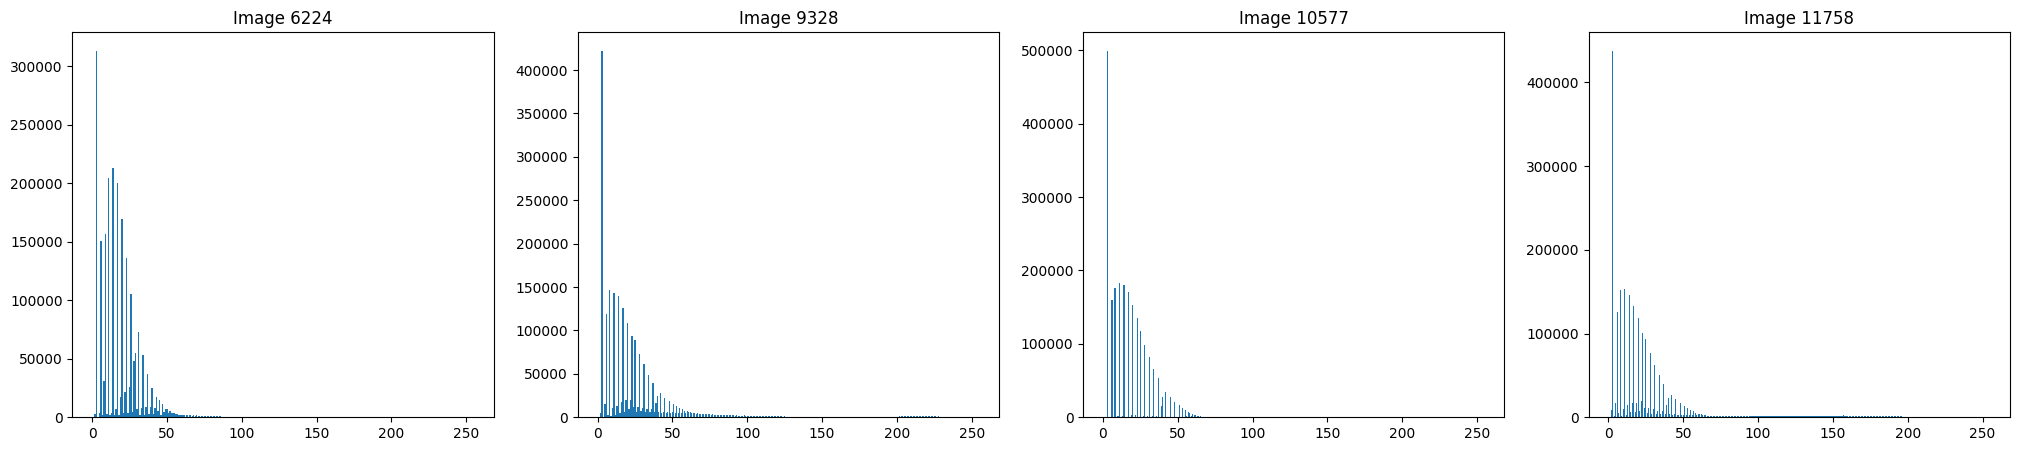

In [7]:
equalized_histograms = compute_histograms(equalized_images)
plot_histograms(equalized_histograms)

Additionally, we increase the image contrast directly by assigning alpha, the contrast control coefficient, a value greater than 1. Beta equal to 1 means keeping the brightness unchanged.

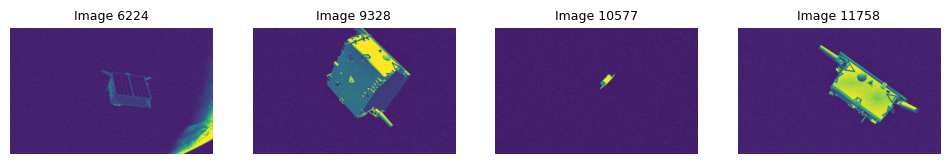

In [8]:
adjusted_images = {}
for filename, equalized_image in equalized_images.items():
    adjusted_image = cv.convertScaleAbs(equalized_image, alpha=1.5, beta=1.0)
    # adjusted_image = cv.addWeighted(equalized_image, 1.5, equalized_image, 0, 1.0)
    adjusted_images[filename] = adjusted_image

display_images(adjusted_images)

Next, we apply image sharpening to enhance the edges and fine details in an image by increasing the contrast between adjacent pixels.

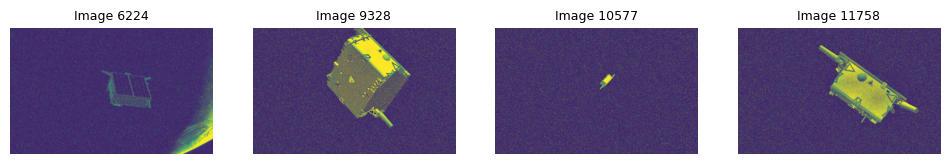

In [9]:
sharpened_images = {}
for filename, adjusted_image in adjusted_images.items():
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened_image = cv.filter2D(adjusted_image, -1, sharpening_kernel)
    sharpened_images[filename] = sharpened_image

display_images(sharpened_images)

Finally, we resize the images so that less computational power and time will be required to train the neural network.

### **Extracting Deep Features with a convolutional autoencoder**

It's time to put deep learning in the game, but calm down, because it's not intended to make any prediction yet. At first, a convolutional autoencoder (CAE) neural network is implemented to learn to reconstruct images in a encoder-decoder architecture. The trained encoder will be later used as a feature extractor for the prediction model.

Let's start by gathering all the transformations applied in the steps above into a single image preprocessing pipeline. The image resizing at the end of the pipeline is added to decrease the input size and make processing computationally less expensive.

The key difference here is that the whole training dataset will be fed into the CAE network rather than only the four images previously.

In [10]:
NUMBER_IMAGES = 1000
RATIO = 5

original_shape = sharpened_images[selected_files[0]].shape
new_shape = (original_shape[0]//RATIO, original_shape[1]//RATIO)

files = os.listdir(TRAIN_SUBSET_PATH)
files.sort()
dataset = []
for i, file_name in enumerate(files):
    if i > NUMBER_IMAGES:
        break
    image = cv.imread(f"{TRAIN_SUBSET_PATH}/{file_name}", cv.IMREAD_GRAYSCALE)
    resized_image = cv.resize(image, new_shape)
    dataset.append(resized_image)
dataset = np.array(dataset)

f"Dataset size: {dataset.shape}"

'Dataset size: (1001, 384, 240)'

Then, we define the CAE's architecture, instantiate, compile and visualize our model. Note that all network's parameters are trainable at this point.

In [11]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

FILTERS = [32, 16,  8]
KERNEL_SIZE = (3, 3)
POOL_SIZE = (2, 2)
ACTIVATION = "relu"
PADDING = "same"
OPTIMIZER = "adam"
LOSS = "mse"

input_shape = (dataset.shape[1], dataset.shape[2], 1)

encoder = models.Sequential([
    Input(shape=input_shape),
    Conv2D(FILTERS[0], KERNEL_SIZE, activation=ACTIVATION, padding=PADDING),
    MaxPooling2D(POOL_SIZE, padding=PADDING),
    Conv2D(FILTERS[1], KERNEL_SIZE, activation=ACTIVATION, padding=PADDING),
    MaxPooling2D(POOL_SIZE, padding=PADDING),
    Conv2D(FILTERS[2], KERNEL_SIZE, activation=ACTIVATION, padding=PADDING),
    MaxPooling2D(POOL_SIZE, padding=PADDING)
])

decoder = models.Sequential([
    Conv2D(FILTERS[2], KERNEL_SIZE, activation=ACTIVATION, padding=PADDING),
    UpSampling2D(POOL_SIZE),
    Conv2D(FILTERS[1], KERNEL_SIZE, activation=ACTIVATION, padding=PADDING),
    UpSampling2D(POOL_SIZE),
    Conv2D(FILTERS[0], KERNEL_SIZE, activation=ACTIVATION, padding=PADDING),
    UpSampling2D(POOL_SIZE),
    Conv2D(1, KERNEL_SIZE, padding=PADDING)
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(optimizer=OPTIMIZER, loss=LOSS)

encoder.summary()


2025-03-06 23:40:17.351367: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 23:40:17.352430: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 23:40:17.354733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 23:40:17.362452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741315217.378904   43976 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741315217.38

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 384, 240, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 192, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 120, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 96, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 60, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 30, 8)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,104 (23.84 KB)

 Trainable params: 6,104 (23.84 KB)

 Non-trainable params: 0 (0.00 B)

Finally, the CAE model is trained over a specific number of epochs and batch size, reserving 20% of the dataset for validation. Additionally, the early stopping mechanism based on validation error is set to prevent overfitting.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

autoencoder.fit(dataset, dataset, 
                validation_split=VALIDATION_SPLIT,
                callbacks=[early_stopping],
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 198.7817 - val_loss: 122.9402
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 94.6383 - val_loss: 80.6526
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 72.4131 - val_loss: 70.4637
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 981ms/step - loss: 65.5181 - val_loss: 65.7679
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 61.9604 - val_loss: 62.7904
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 57.1422 - val_loss: 60.5243
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 56.3039 - val_loss: 58.6684
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 54.4784 - val_loss: 57.4411
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 52.0250 - val_loss: 55.7769
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 52.9165 - val_loss: 62.1897
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 56.4000 - val_loss: 54.3944
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/s

With the model trained, we run it to reconstruct four new random images from the dataset.

In [15]:
original_images = dataset[np.random.randint(0, len(dataset), 4)]
reconstructed_images = autoencoder.predict(original_images)
reconstructed_images = np.squeeze(reconstructed_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Now, it's possible to compare the original and reconstructed image pairs to check how well the model can reconstruct images from their encoded representation. 

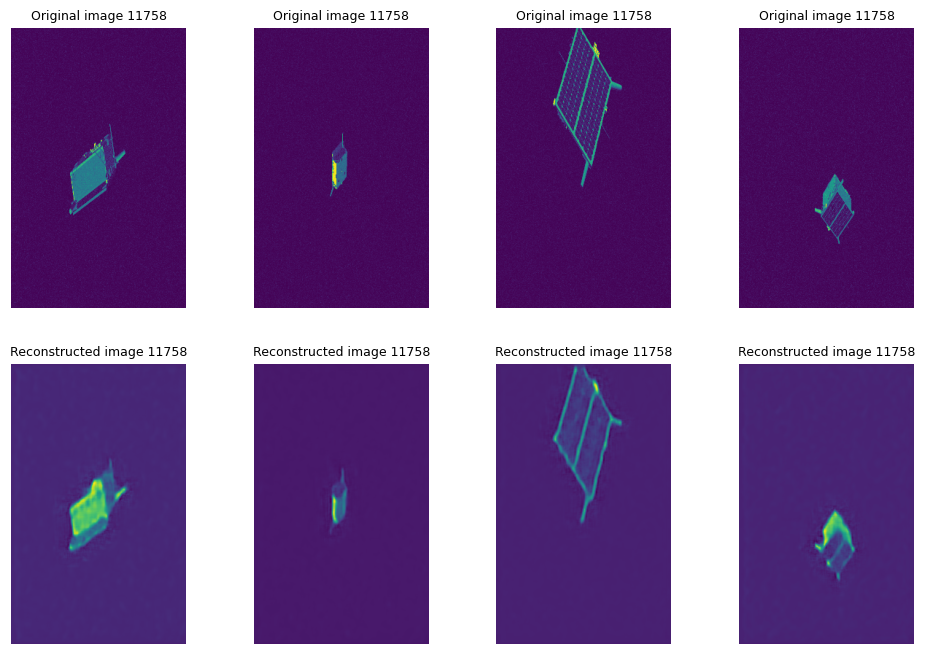

In [16]:
def compare_images(original_images, reconstructed_images):
    fig, axes = plt.subplots(2, len(images), figsize=(12, 8))
    for i, (original_image, reconstructed_image) in enumerate(zip(original_images, reconstructed_images)):
        axes[0, i].imshow(original_images[i])
        axes[0, i].set_title(f"Original image {filename}", fontsize=9)
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed_images[i])
        axes[1, i].set_title(f"Reconstructed image {filename}", fontsize=9)
        axes[1, i].axis("off")

compare_images(original_images, reconstructed_images)